In [109]:
# run command:$ jupyter nbconvert --to notebook --inplace --execute main.ipynb

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import GridSearch
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import os

In [82]:
# define the scaler
scaler = MinMaxScaler()

# label encoder
label_encoder = LabelEncoder()

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# Normalize the data
images_normalized = scaler.fit_transform(images)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.1)

# Print the shape of the dataset
print("(Number of images, Shape of images):", images.shape)
print("(Number of labels):", labels.shape)

(Number of images, Shape of images): (70000, 784)
(Number of labels): (70000,)


In [83]:
# Perform PCA
features = 78
pca = PCA(n_components=features)  # Reduce the dimensionality to 2 for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

# Get the most relevant features (pixels) for the first principal component
most_relevant_features = np.argsort(pca.components_[0])[-features:][::-1]

# Compute the reconstruction error
X_train_reconstructed = pca.inverse_transform(X_train_pca)
reconstruction_error = np.mean(np.square(X_train - X_train_reconstructed))

# Print the reconstruction error
print("Reconstruction Error:", reconstruction_error)


Reconstruction Error: 0.1293717009181705


In [104]:
# Perform Isolation Forest
isolation_forest = IsolationForest()
isolation_forest.fit(X_train)

# Predict outliers
outliers_train = isolation_forest.predict(X_train)
outliers_test = isolation_forest.predict(X_test)

# Print the number of outliers detected
print("Number of outliers in training data:", np.sum(outliers_train == -1))
print("Number of outliers in test data:", np.sum(outliers_test == -1))

Number of outliers in training data: 11134
Number of outliers in test data: 1296


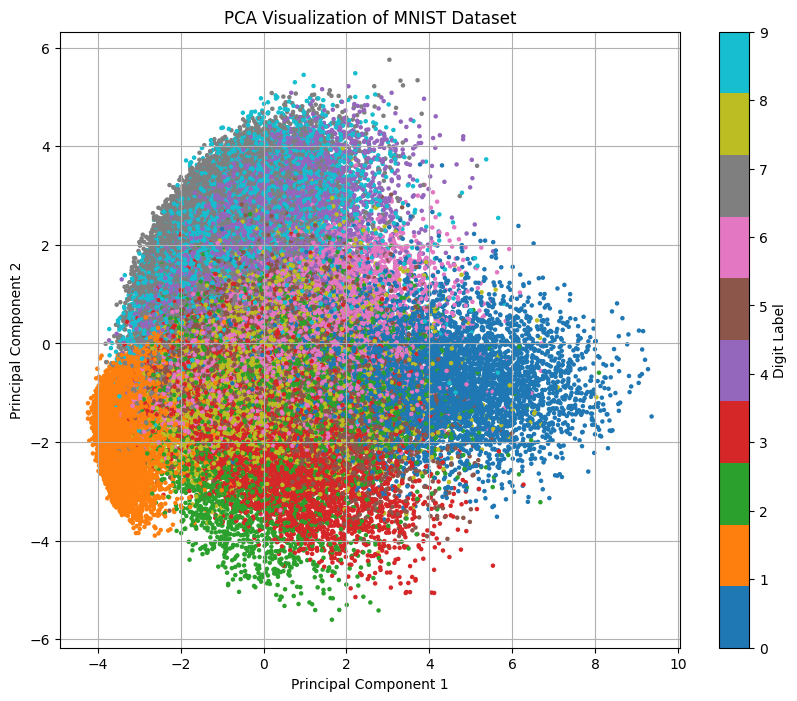

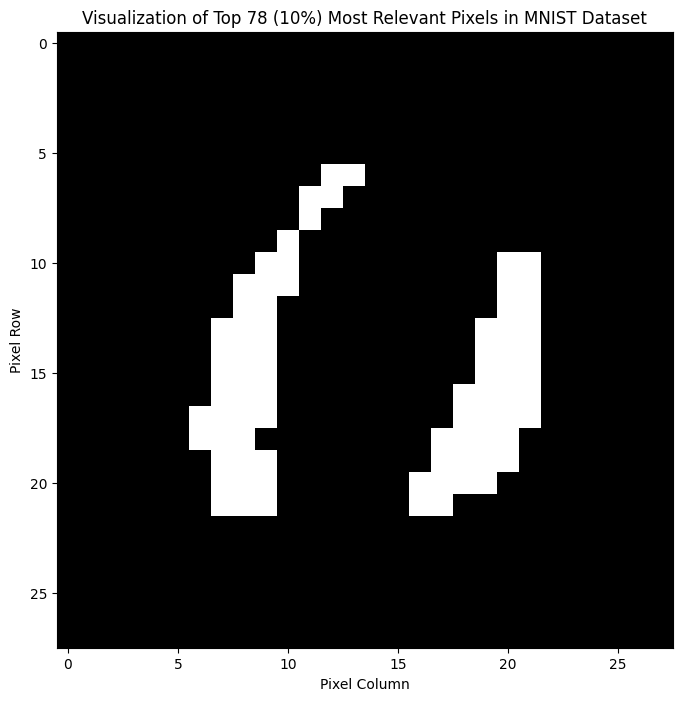

In [84]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.astype(int), cmap='tab10', s=5)
plt.colorbar(label='Digit Label')
plt.title('PCA Visualization of MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()

# Create a 28x28 grid
grid = np.zeros((28, 28))

# Set the value of the top 10 most relevant pixels to 1
top_pixels = np.argsort(pca.components_[0])[-features:]
for pixel_idx in top_pixels:
    row_idx = pixel_idx // 28
    col_idx = pixel_idx % 28
    grid[row_idx, col_idx] = 1

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='gray', interpolation='nearest')
plt.title('Visualization of Top 78 (10%) Most Relevant Pixels in MNIST Dataset')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.grid(False)
plt.show()

In [85]:
#KNN
k = int(np.sqrt(7000))
clf_knn = KNeighborsClassifier(n_neighbors=k)

# train the model
clf_knn.fit(X_train, y_train)

# Evaluate the model
accuracy = clf_knn.score(X_test, y_test)
print("Accuracy of KNN classifier:", accuracy)

Accuracy of KNN classifier: 0.9437142857142857


In [86]:
# Define the SVM model
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')

# train the model
svm_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy of SVM classifier:", accuracy)


Accuracy of SVM classifier: 0.9864285714285714


In [93]:
# GBT takes a really long time to run
# Define the Gradient Boosting model
clf_gbt = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    verbose=0,
)

# train the model
clf_gbt.fit(X_train, y_train)

# Evaluate the model
accuracy = clf_gbt.score(X_test, y_test)
print("Accuracy of GBT classifier:", accuracy)

Accuracy of GBT classifier: 0.8465714285714285


In [88]:
# define the Convolutional Neural Network

tensorboard_callback = TensorBoard(log_dir="./logs")

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Convert labels to integer format for CNN
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape data for CNN input, inputs are 28x28 gray scale
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

# train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_reshaped, y_train_encoded, epochs=5, callbacks=[tensorboard_callback])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped,  y_test_encoded, verbose=0)
print("Accuracy of CNN classifier:", test_acc)


Epoch 1/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8948 - loss: 0.3355
Epoch 2/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9856 - loss: 0.0439
Epoch 3/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9899 - loss: 0.0327
Epoch 4/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9913 - loss: 0.0262
Epoch 5/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9947 - loss: 0.0177
Accuracy of CNN classifier: 0.9901428818702698


In [116]:
# Parameter tunning
# Define the model building function
def build_model(hp):
    model = keras.Sequential()
    # Convolutional layers apply a set of learnable filters to input data.
    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    # Max pooling layers downsample the input along the spatial dimensions 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    #  Flattens the input tensor into a 1-dimensional tensor.
    model.add(layers.Flatten())
    # perform a linear transformation followed by an activation function.
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dense(10))

    model.compile(optimizer='adam',do
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# Instantiate label encoder
label_encoder = LabelEncoder()

# Convert labels to integer format for CNN
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape data for CNN input, inputs are 28x28 gray scale
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

# Instantiate the tuner
tuner = GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='grid_search',
    project_name='mnist_cnn_grid_search'
)

# Perform the hyperparameter search
tuner.search(X_train_reshaped, y_train_encoded, epochs=5, validation_data=(X_test_reshaped, y_test_encoded))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train_reshaped, y_train_encoded, epochs=5, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(X_test_reshaped, y_test_encoded)
print("Accuracy of the best model:", test_acc)


Reloading Tuner from grid_search/mnist_cnn_grid_search/tuner0.json
Epoch 1/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9016 - loss: 0.3084 - val_accuracy: 0.9844 - val_loss: 0.0518
Epoch 2/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9858 - loss: 0.0476 - val_accuracy: 0.9871 - val_loss: 0.0432
Epoch 3/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9893 - loss: 0.0335 - val_accuracy: 0.9904 - val_loss: 0.0315
Epoch 4/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9931 - loss: 0.0225 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 5/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9948 - loss: 0.0169 - val_accuracy: 0.9903 - val_loss: 0.0272
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0213
Accuracy of the best model: 0.9902856945991516


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


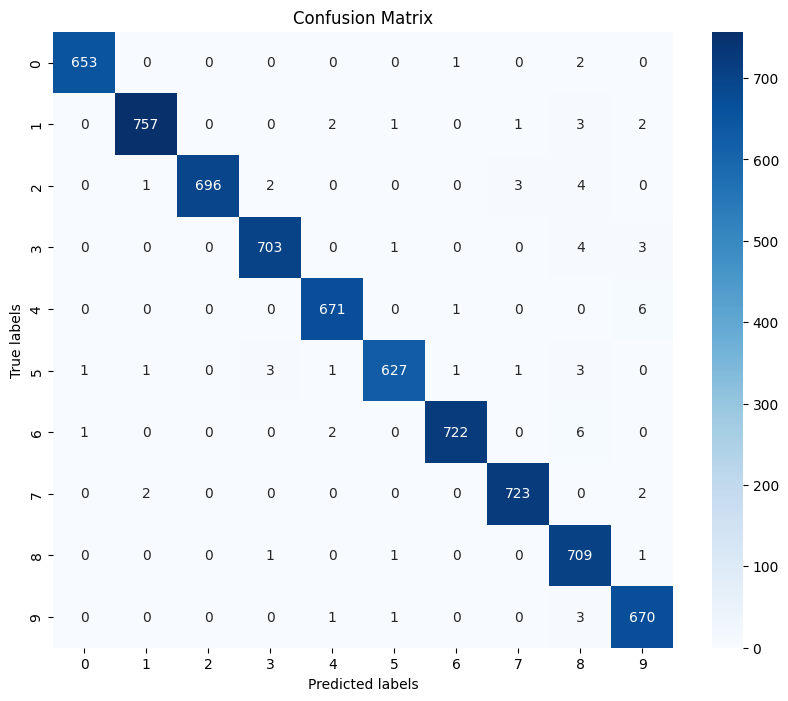

In [144]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on test data
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


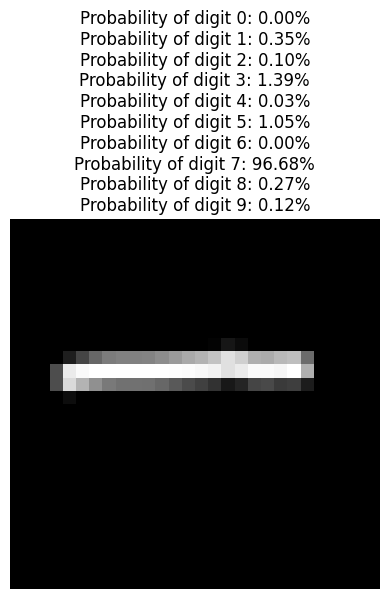

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


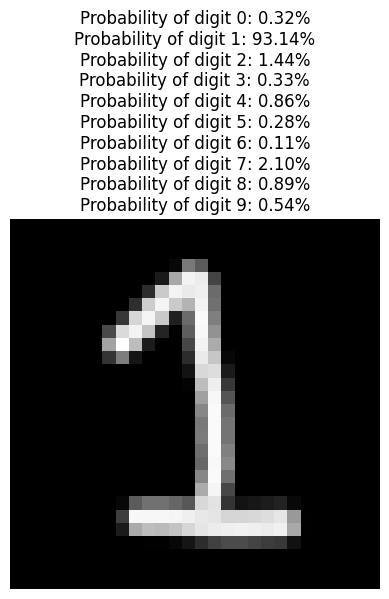

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


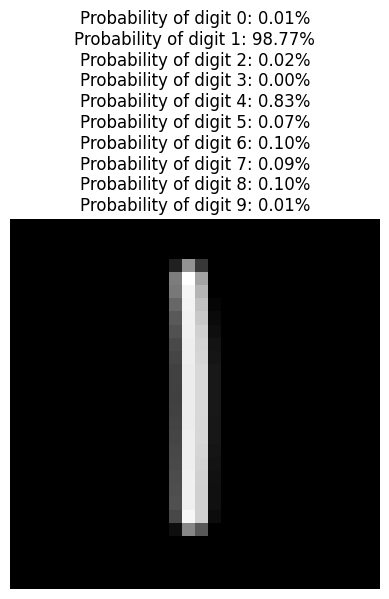

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


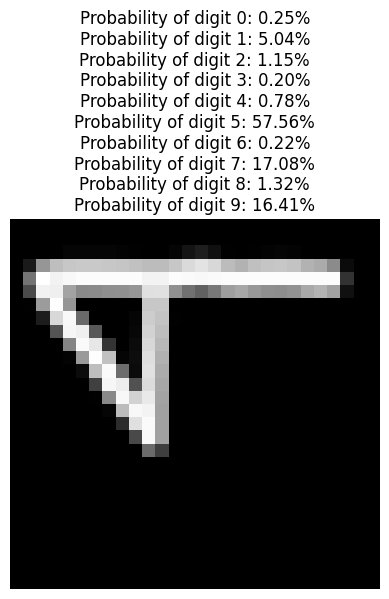

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


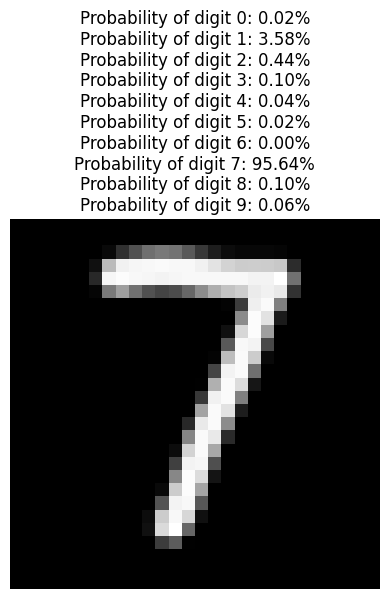

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


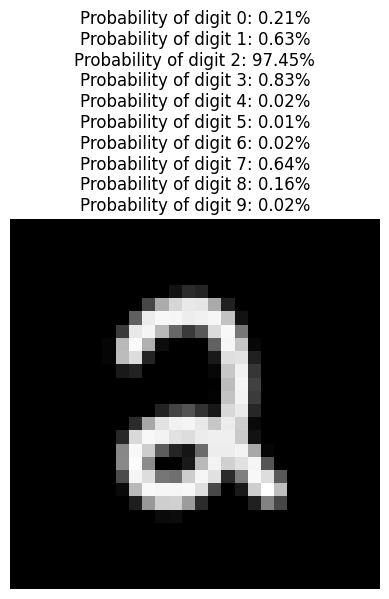

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


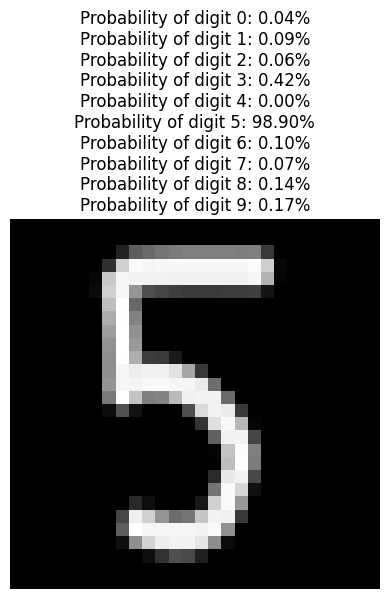

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


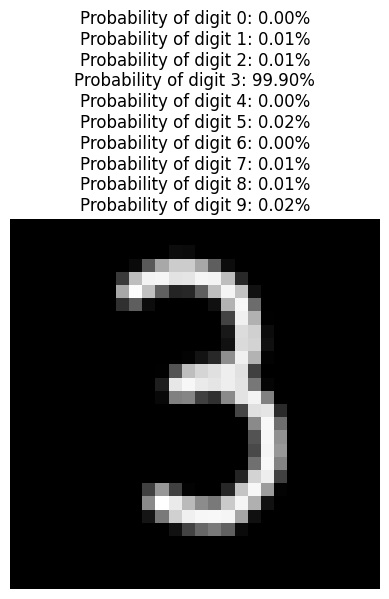

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


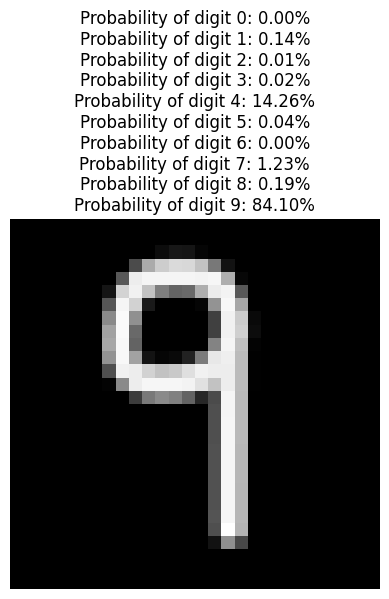

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


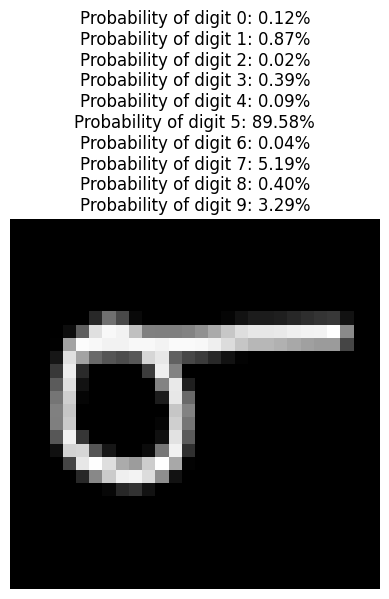

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


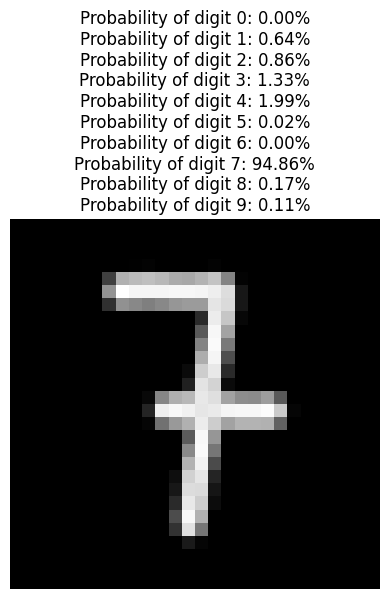

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


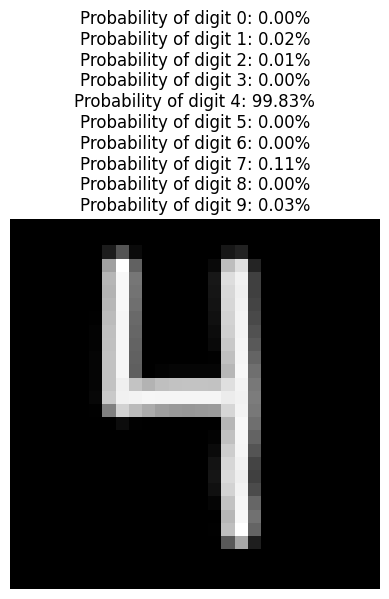

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


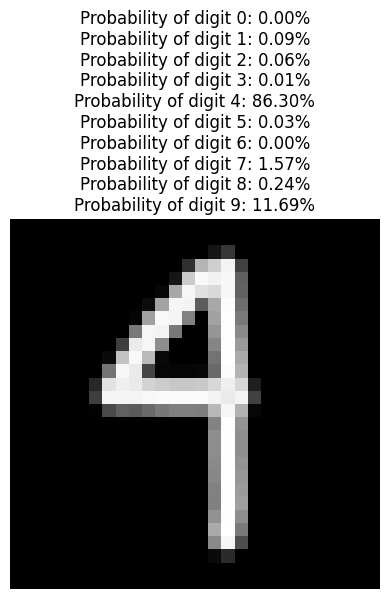

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


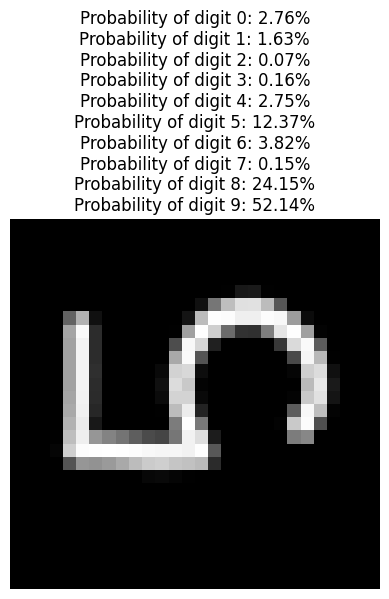

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


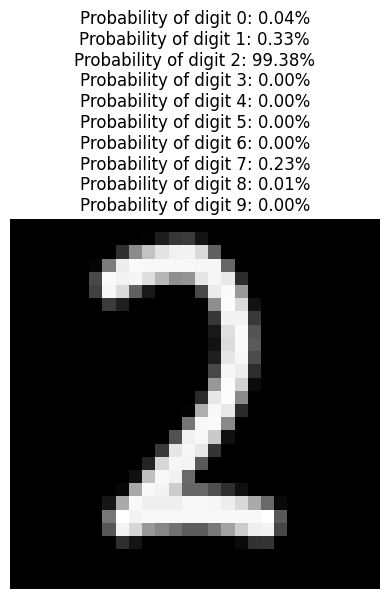

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


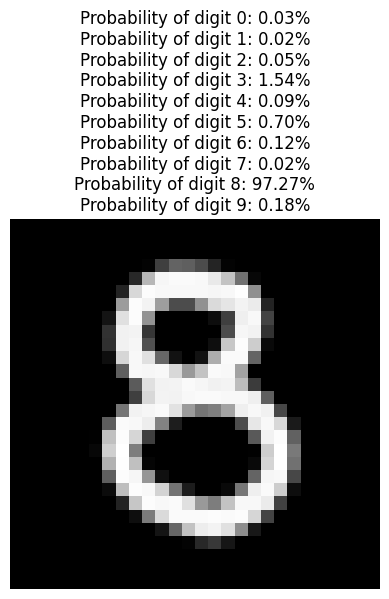

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


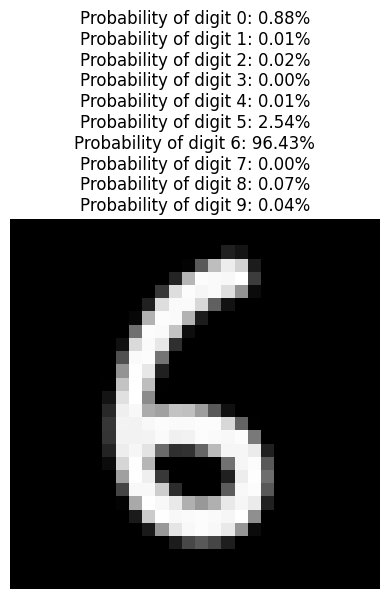

In [140]:
# convert an image I drew to test the model with

# Directory containing images
directory = "images/"

# Iterate through each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        # Load the handwritten image as grayscale
        image = Image.open(os.path.join(directory, filename)).convert("L")

        # Resize the image to 28x28 pixels
        image = image.resize((28, 28))

        # Invert the pixel values
        image = ImageOps.invert(image)

        # Convert the image to a numpy array
        image_array = np.array(image)

        # Flatten the image array
        image_flattened = image_array.flatten()

        # Scale the pixel values to the range [0, 1]
        # this is equivalent to using the MinMaxScaler()
        image_scaled = image_flattened / 255.0

        # Predict the label using the other trained models
        predicted_label_svm = svm_classifier.predict([image_scaled])[0]
        predicted_label_gbt = clf_gbt.predict([image_scaled])[0]
        predicted_label_knn = clf_knn.predict([image_scaled])[0]

        # Predict with CNN
        ni = image_scaled.reshape(-1, 28, 28, 1)
        logits = model.predict([ni])[0]
        predicted_label_cnn = np.argmax(logits) # make the prediction the index with highest value
        # Display the percentages 
        probs = np.exp(logits) / np.sum(np.exp(logits)) # Apply softmax function
        percentages = probs * 100 # Convert to percentages
        # Convert percentages to strings with 2 decimal places and add a '%' sign
        percentage_strings = [f'{percentage * 100:.2f}' for percentage in percentages]

        # Join percentage strings with their corresponding digit labels
        titles = [f'Probability of digit {i}: {(float(percentage)/100):.2f}%' for i, percentage in enumerate(percentage_strings)]

        # define an image that can be shown to compare to the prediction
        image_to_show = image_scaled.reshape(28, 28)

        # Display the image along with the predicted labels
        plt.imshow(image_to_show, cmap='gray')
        plt.axis('off')
        plt.title('\n'.join(titles))
        plt.show()
